# 3-peaks pattern recognizer

In [20]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math

In [32]:
df = dl.get_minutely_data("HNTUSDT", past=False)
df1 = df.set_index("timestamp")
df["timestamp"] = list(map(lambda x: datetime.utcfromtimestamp(x / 1e3), df.timestamp))
df.set_index("timestamp", inplace=True)

In [19]:
a = df.to_numpy()

In [28]:
ma = df.open.rolling(window=10000).mean().diff()

In [107]:
def find_pivots(df, unit = 1000):
    """returns timestamps of peaks"""
    i = 0
    price = df.open.to_list()
    timestamps = df.timestamp.to_list()
    h_ts = [] #high timestamps
    l_ts = []
    past = price[0]
    now = price[0]
    future = price[unit]
    while True:
        if now>past and now>future:
            h_ts.append(timestamps[i])
        elif now<past and now<future:
            l_ts.append(timestamps[i])
        i += unit
        past = now
        now = future
        try:
            future = price[i+unit]
        except:
            break
    return h_ts, l_ts
                

In [112]:
h, l = find_pivots(df)

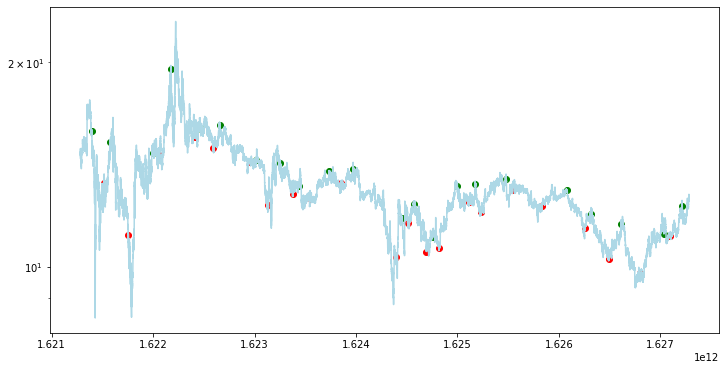

In [113]:

fig, ax = plt.subplots(figsize=(12, 6))
plotdf = df[-200000:-100000]
h = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, h))
l = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, l))

plt.yscale("log")
ax.plot(plotdf.set_index("timestamp").open, c="lightblue")
ax.scatter(h, plotdf.set_index("timestamp").reindex(h)["open"], c="green")
ax.scatter(l, plotdf.set_index("timestamp").reindex(l)["open"], c="red")

In [ ]:
def get_daily_vol(close, span0=10000):
    """
    daily vol, reindexed to close
    
    Arguments:
    close -- daily close (probably Pandas series)
    span0 -- span lol (probably int)
    Purpose:
    use the output of this function to set default profit taking and stop-loss limit
    """
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=2))
    df0=df0[df0>0]
    df0=pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    df0=df0.ewm(span=span0).std()
    return df0

In [56]:
def timedelta(days):
    """returns number of minutes in days"""
    return days*24*60*60000

def get_daily_vol(close, span0=10000):
    """
    daily vol, reindexed to close
    
    Arguments:
    close -- daily close (probably Pandas series)
    span0 -- span lol (probably int)
    Purpose:
    use the output of this function to set default profit taking and stop-loss limit
    """
    df0 = close.index.searchsorted(close.index-timedelta(days=2))
    df0=df0[df0>0]
    df0=pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    df0=df0.ewm(span=span0).std()
    return df0

In [57]:
vol = get_daily_vol(df1.open)

In [58]:
vol

timestamp
1601110860000         NaN
1601110920000    0.502381
1601110980000    0.383427
1601111040000    0.322004
1601111100000    0.279546
                   ...   
1634100840000    0.046064
1634100900000    0.046061
1634100960000    0.046057
1634101020000    0.046053
1634101080000    0.046050
Name: open, Length: 548494, dtype: float64

In [ ]:
vol

timestamp
2020-09-26 09:01:00         NaN
2020-09-26 09:02:00    0.502381
2020-09-26 09:03:00    0.383427
2020-09-26 09:04:00    0.322004
2020-09-26 09:05:00    0.279546
                         ...   
2021-10-13 04:54:00    0.046064
2021-10-13 04:55:00    0.046061
2021-10-13 04:56:00    0.046057
2021-10-13 04:57:00    0.046053
2021-10-13 04:58:00    0.046050
Name: open, Length: 548494, dtype: float64

In [69]:
def get_t_events(g_raw, h, m):
    """
    Implementation of the symmetric CUSUM filter seen in chapter 2.5.2
    
    Arguments:
    g_raw -- the raw time series to filter (possibly pandas series)
    h -- threshold pandas series vol
    m -- minimum threshold (float, ex: 0.02)
    
    Purpose:
    The CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a measured quantity away from a target value. 
    """
    h = h.map(lambda x: x if x>=m else m)
    t_events, s_pos, s_neg = [], 0, 0
#     side = []
    diff = np.log(g_raw).diff().dropna()
    for i in diff.index[1:]:
        try:
            pos, neg = float(s_pos+diff.loc[i]), float(s_neg+diff.loc[i])
        except Exception as e:
            print(e)
            print(s_pos+diff.loc[i], type(s_pos+diff.loc[i]))
            print(s_neg+diff.loc[i], type(s_neg+diff.loc[i]))
            break
        s_pos, s_neg=max(0., pos), min(0., neg)
        try: 
            th = h.loc[i]
        except:
            try:
                th = h[h.index.get_loc(i, method="pad")]
            except: #i is before the first ever h
                continue
        if s_neg<-th:
            s_neg=0
            t_events.append(i)
#             side.append(0)
        if s_pos>th:
            s_pos=0
            t_events.append(i)
#             side.append(1)
#     return pd.DatetimeIndex(t_events)
    return t_events

In [77]:
t_events = get_t_events(df1.close,h=vol, m=0.01)
t_events

[1601110860000,
 1601110860000,
 1601123940000,
 1601127060000,
 1601189580000,
 1601234580000,
 1601266320000,
 1601273760000,
 1601276640000,
 1601281440000,
 1601296980000,
 1601329800000,
 1601335020000,
 1601396640000,
 1601419860000,
 1601544540000,
 1601567760000,
 1601698560000,
 1601757420000,
 1601806200000,
 1601827260000,
 1601879100000,
 1601921700000,
 1601970300000,
 1601982900000,
 1601996400000,
 1601999040000,
 1602010500000,
 1602044580000,
 1602079200000,
 1602084960000,
 1602098820000,
 1602117720000,
 1602159960000,
 1602313440000,
 1602499320000,
 1602695700000,
 1602839640000,
 1603063440000,
 1603149660000,
 1603209660000,
 1603295580000,
 1603378860000,
 1603465320000,
 1603471140000,
 1603621380000,
 1603668960000,
 1603683960000,
 1603702260000,
 1603726620000,
 1603733700000,
 1603774620000,
 1603815300000,
 1603868220000,
 1603919700000,
 1603958880000,
 1604016420000,
 1604036280000,
 1604210100000,
 1604232480000,
 1604321100000,
 1604371680000,
 1604476

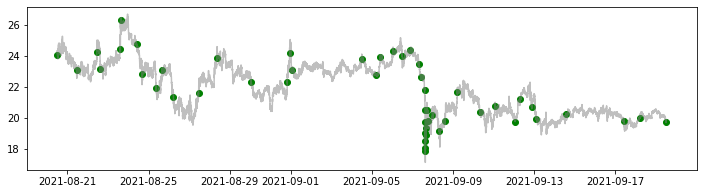

In [8]:
t_range = t_events[-100:-50]
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(t_range, df.reindex(t_range).open, c="green")
ax.plot(df[(df.index>t_range[0]) & (df.index<t_range[-1])].open, c="gray", alpha=0.5)

In [86]:
def add_vertical_barrier(t_events, close, num_days=1):
    """
    Snippet 3.4, indended to be used on t1"""
#     t1=close.index.searchsorted(t_events+timedelta(days=num_days))
    shift = timedelta(days=num_days)
    t1=close.index.searchsorted(list(map(lambda x: x+shift, t_events)))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=t_events[:t1.shape[0]]))
    return t1

In [87]:
t1 = add_vertical_barrier(t_events, df1.close, num_days=1)
t1

1601110860000    1601197260000
1601110860000    1601197260000
1601123940000    1601210340000
1601127060000    1601213460000
1601189580000    1601275980000
                     ...      
1633584180000    1633670580000
1633661700000    1633748100000
1633827960000    1633914360000
1633924020000    1634010420000
1633975200000    1634061600000
Name: timestamp, Length: 788, dtype: int64

## TODO: Continue from metalabelling and convert time index to int index

In [14]:
lookback = 4000
def get_z_score(a, b):
    """Returns the latest zscore between dataframes a and b. IF NAN, RETURN PREVIOUS"""
    a = a.set_index("timestamp") #Do not set inplace cause reference
    b = b.set_index("timestamp")

    df = pd.to_numeric(a.open.rename("A")).to_frame()
    df["B"] = pd.to_numeric(b.open)

    df.dropna(inplace=True)

    results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
    hr = results.params[1]
    spread = pd.Series((df['B'] - hr * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(lookback).mean()
    spread["std"] = spread.spread.rolling(lookback).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
    return get_non_nan_zscore(spread)    
    
def get_non_nan_zscore(spread):
    """loops through spread finding latest non-nan zscore"""
    zscore = spread.iloc[-1].zscore
    i = 2
    while math.isnan(zscore):
        zscore = spread.iloc[-i].zscore
        i += 1
    return zscore

In [10]:
a = dl.get_minutely_data("HNTUSDT", past=False)
b = dl.get_minutely_data("BTCUSDT", past=False)

In [17]:
z = get_z_score(a, b)

In [18]:
z

-0.15050287861225423